In [1]:
import math

import numpy as np
M1 = np.array([20000, 0, 2000])
f1 = np.array([17800, 0, 1800])
v_f1 = 120
v_M1 = 300
v_smoke = -3
gravity = 9.80655
fake_target = np.array([0,0,0])
true_target = np.array([0, 200, 5])  #此为质心，高为10，半径为7
true_target_R = 7
true_target_H = 10
smoke_R = 10
true_target_corner_1 = true_target - np.array([0, true_target_R, true_target_H / 2])
true_target_corner_2 = true_target - np.array([0, true_target_R, -true_target_H / 2])
true_target_corner_3 = true_target - np.array([0, -true_target_R, true_target_H / 2])
true_target_corner_4 = true_target - np.array([0, -true_target_R, -true_target_H / 2])


true_target_corners = np.array([true_target_corner_1, true_target_corner_2, true_target_corner_3, true_target_corner_4])



def vectorized_intersection(missile_positions, target_corners, smoke_centers, radius=10):
    """
    判断导弹到每个目标角点的线段与烟幕球是否相交（纯numpy实现，无列表操作）
    
    参数:
        missile_positions: 导弹位置数组，形状为 (n_time_steps, 3)
        target_corners: 目标角点数组，形状为 (4, 3)
        smoke_centers: 烟幕中心数组，形状为 (n_time_steps, 3)
        radius: 烟幕半径
        
    返回:
        布尔数组，形状为 (n_time_steps, )，每个元素表示该时间步四个角点是否都在烟幕范围内
    """
    corners_expanded = target_corners[:, np.newaxis, :]  # 形状 (4, 1, 3)
    line_dir = corners_expanded - missile_positions
    
    # 线段长度平方 (4, n)
    line_len_sq = np.sum(line_dir **2, axis=2)
    line_len_sq = np.maximum(line_len_sq, 1e-10)  # 防止除零
    
    # 导弹到烟幕球心的向量 (4, n, 3)
    vec_missile_to_smoke = smoke_centers - missile_positions
    vec_missile_to_smoke = np.expand_dims(vec_missile_to_smoke, axis=0)  # 扩展为 (1, n, 3) 以便广播
    
    t = np.sum(vec_missile_to_smoke * line_dir, axis=2) / line_len_sq
    t = np.clip(t, 0, 1)  # 限制在segment上
    
    closest_points = missile_positions + np.expand_dims(t, axis=2) * line_dir
    
    distances = np.linalg.norm(closest_points - smoke_centers, axis=2)
    
    # 判断每个角点是否在烟幕内 (4, n)，再检查每个时间步是否所有角点都满足
    return np.all(distances <= radius, axis=0)


def calc_cover_intervals(f_speed, f_dir, t_release, t_burst, smoke_v0=-3):
    """
    计算遮蔽时间区间（修复烟幕位置、变量定义等错误）
    参数修正：
        f_dir: 无人机飞行方向角（弧度，而非3维向量），水平飞行（z=0）
    """
    
    t_list = np.linspace(0, 60, 6001, dtype=np.float32)
    time_step = t_list[1] - t_list[0]  # 时间步长（0.0005秒）
    
    # 4. 方向向量计算（修正无人机方向向量逻辑）
    dir_vec = (fake_target - M1) / np.linalg.norm(fake_target - M1)  # 导弹方向（单位向量）
    f_dir_vec = np.array([np.cos(f_dir), np.sin(f_dir), 0], dtype=np.float32)  # 无人机方向（单位向量）
    
    # 5. 烟幕起爆时刻（相对于t_list起始点的绝对时间）
    t_burst_abs = t_release + t_burst  # 烟幕起爆的绝对时间（秒）
    
    mask_burst = t_list >= t_burst_abs  # 筛选起爆后的时间步
    t_list_burst = t_list[mask_burst]  # 起爆后的时间序列（相对t_list起始点）
    missile_from_burst = M1 + v_M1 * t_list_burst[:, np.newaxis] * dir_vec  # 起爆后的导弹位置
    '''
        这里把投放后干扰弹额水平运动也计入了无人机的水平运动
    '''
    smoke_position0 = (
        f1 
        + f_speed * (t_release+t_burst) * f_dir_vec 
        - np.array([0, 0, 0.5 * gravity * t_burst**2])  # 烟幕弹投放后下落t_burst时间的位移（仅z方向）
    )
    
    t_since_burst = t_list_burst - t_burst_abs  #
    smoke_positions = smoke_position0 + np.array([0, 0, smoke_v0]) * t_since_burst[:, np.newaxis]
    
    # 8. 判断相交（仅对起爆后的时间步计算）
    insmoke = vectorized_intersection(
        missile_positions=missile_from_burst,
        target_pos=true_target_corners,
        smoke_centers=smoke_positions,
        radius=10
    )
    # 9. 计算遮蔽时间区间（修正结束时间逻辑）
    valid_indices = np.where(insmoke)[0]  # 有效遮蔽的索引（相对于t_list_burst）
    if len(valid_indices) == 0:
        print("无有效遮蔽时间")
        return 0.0
    
    # 起始时间：第一个有效遮蔽的绝对时间
    start_idx = valid_indices[0]
    start_time_abs = t_list_burst[start_idx]
    
    # 结束时间：最后一个有效遮蔽的绝对时间
    end_idx = valid_indices[-1]
    end_time_abs = t_list_burst[end_idx]
    
    # 总遮蔽时间（结束-起始，加上一个时间步长，确保包含最后一步）
    total_time = end_time_abs - start_time_abs + time_step
    
    # 打印结果（相对于烟幕起爆时刻的时间）
    start_time_rel = start_time_abs - t_burst_abs
    end_time_rel = end_time_abs - t_burst_abs
    print(f"始遮蔽时间：{start_time_rel:.4f}s, 结束遮蔽时间：{end_time_rel:.4f}s")
    return total_time



In [2]:
import math

import numpy as np
M1 = np.array([20000, 0, 2000])
f1 = np.array([17800, 0, 1800])
v_f1 = 120
v_M1 = 300
v_smoke = -3
gravity = 9.80655
fake_target = np.array([0,0,0])
true_target = np.array([0, 200, 5])  #此为质心，高为10，半径为7
true_target_R = 7
true_target_H = 10
smoke_R = 10
true_target_corner_1 = true_target - np.array([0, true_target_R, true_target_H / 2])
true_target_corner_2 = true_target - np.array([0, true_target_R, -true_target_H / 2])
true_target_corner_3 = true_target - np.array([0, -true_target_R, true_target_H / 2])
true_target_corner_4 = true_target - np.array([0, -true_target_R, -true_target_H / 2])


true_target_corners = np.array([true_target_corner_1, true_target_corner_2, true_target_corner_3, true_target_corner_4])



def vectorized_intersection(missile_positions, target_corners, smoke_centers, radius=10):
    """
    判断导弹到每个目标角点的线段与烟幕球是否相交（纯numpy实现，无列表操作）
    
    参数:
        missile_positions: 导弹位置数组，形状为 (n_time_steps, 3)
        target_corners: 目标角点数组，形状为 (4, 3)
        smoke_centers: 烟幕中心数组，形状为 (n_time_steps, 3)
        radius: 烟幕半径
        
    返回:
        布尔数组，形状为 (n_time_steps, )，每个元素表示该时间步四个角点是否都在烟幕范围内
    """
    corners_expanded = target_corners[:, np.newaxis, :]  # 形状 (4, 1, 3)
    line_dir = corners_expanded - missile_positions
    
    # 线段长度平方 (4, n)
    line_len_sq = np.sum(line_dir **2, axis=2)
    line_len_sq = np.maximum(line_len_sq, 1e-10)  # 防止除零
    
    # 导弹到烟幕球心的向量 (4, n, 3)
    vec_missile_to_smoke = smoke_centers - missile_positions
    vec_missile_to_smoke = np.expand_dims(vec_missile_to_smoke, axis=0)  # 扩展为 (1, n, 3) 以便广播
    
    t = np.sum(vec_missile_to_smoke * line_dir, axis=2) / line_len_sq
    t = np.clip(t, 0, 1)  # 限制在segment上
    
    closest_points = missile_positions + np.expand_dims(t, axis=2) * line_dir
    
    distances = np.linalg.norm(closest_points - smoke_centers, axis=2)
    
    # 判断每个角点是否在烟幕内 (4, n)，再检查每个时间步是否所有角点都满足
    return np.all(distances <= radius, axis=0)


def calc_cover_intervals(f_speed, f_dir, t_release, t_burst, smoke_v0=-3, smoke_radius=10, g=9.80665):
    """
    计算遮蔽时间区间
    f_speed: 无人机速度(m/s)
    f_dir: 无人机运动方向(3维单位向量, 只能等高, z=0)
    t_release: 投放炸弹的时间数组(s)，长度为3
    t_burst: 投放后多久炸弹起爆的时间数组(s)，长度为3
    smoke_v0: 烟幕弹竖直初速度(默认-3m/s)
    smoke_radius: 烟幕半径(默认10m)
    g: 重力加速度(默认9.80665)
    返回： 遮蔽区间列表，每个元素为(start, end)，以第一个烟幕起爆时为0
    """
    # 固定参数
    m1 = np.array([20000, 0, 2000], dtype=np.float32)
    true_target = np.array([0, 200, 5], dtype=np.float32)
    v_m = 300  # m/s
    f1 = np.array([17800, 0, 1800], dtype=np.float32)  # 无人机1初始位置
    fake_target = np.array([0, 0, 0], dtype=np.float32)
    
    # 计算方向向量
    dir_vec = (fake_target - m1) / np.linalg.norm(fake_target - m1)
    f_dir = np.array([np.cos(f_dir), np.sin(f_dir), 0], dtype=np.float32)

    # 计算最早的起爆时间，作为时间基准
    earliest_burst = min(t_release[i] + t_burst[i] for i in range(3))
    
    # 生成时间数组（从最早起爆时间开始，覆盖所有可能的烟幕存续时间）
    max_duration = max(t_release[i] + t_burst[i] for i in range(3)) + 20 - earliest_burst
    t_list = np.linspace(0, max_duration, int(max_duration * 2000) + 1, dtype=np.float32)
    
    # 计算导弹位置随时间变化
    missile_positions = m1[:, np.newaxis] + v_m * (earliest_burst + t_list) * dir_vec[:, np.newaxis]
    
    # 初始化总遮蔽状态
    total_in_smoke = np.zeros_like(t_list, dtype=bool)
    
    # 处理每个烟幕弹
    for i in range(3):
        # 计算该烟幕弹的起爆时间和位置
        burst_time_absolute = t_release[i] + t_burst[i]
        burst_time_relative = burst_time_absolute - earliest_burst
        
        # 无人机投放位置
        f_release = f1 + f_speed * burst_time_absolute * f_dir
        
        # 烟幕弹起爆点（投放后t_burst秒，抛体运动）
        smoke_burst = np.array([
            f_release[0], 
            f_release[1], 
            f_release[2] + (-0.5) * g * t_burst[i]**2
        ], dtype=np.float32)
        
        # 计算烟幕弹在相对时间t_list中的位置
        # 只在烟幕弹起爆后且有效期内计算
        valid_indices = np.where((t_list >= burst_time_relative) & (t_list <= burst_time_relative + 20))[0]
        if len(valid_indices) == 0:
            continue
        
        # 烟幕弹在有效时间内的相对时间
        t_smoke = t_list[valid_indices] - burst_time_relative
        
        # 计算烟幕位置
        smoke_z = smoke_burst[2] + smoke_v0 * t_smoke
        smoke_positions = np.stack([
            np.full_like(t_smoke, smoke_burst[0]),
            np.full_like(t_smoke, smoke_burst[1]),
            smoke_z
        ], axis=0)
        
        # 导弹在对应时间的位置
        missile_positions_valid = missile_positions[:, valid_indices]
        
        # 计算是否有交集（视线被烟幕遮挡）
        d = true_target[:, np.newaxis] - missile_positions_valid  # 目标到导弹的向量
        d_norm2 = np.sum(d **2, axis=0)  # 向量d的模方
        
        f = missile_positions_valid - smoke_positions  # 导弹到烟幕中心的向量
        a = d_norm2
        b = 2 * np.sum(d * f, axis=0)  # 2*(d·f)
        c = np.sum(f** 2, axis=0) - smoke_radius **2  # |f|² - r²
        
        delta = b** 2 - 4 * a * c  # 判别式
        sqrt_delta = np.sqrt(np.maximum(delta, 0))  # 避免负数开方
        
        with np.errstate(divide='ignore', invalid='ignore'):
            s1 = (-b - sqrt_delta) / (2 * a)
            s2 = (-b + sqrt_delta) / (2 * a)
        in_smoke = ((0 <= s1) & (s1 <= 1)) | ((0 <= s2) & (s2 <= 1))
        in_smoke[delta < 0] = False
        
        # 更新总遮蔽状态
        total_in_smoke[valid_indices] = total_in_smoke[valid_indices] | in_smoke
    
    # 计算遮蔽区间
    intervals = []
    if np.any(total_in_smoke):
        # 找到状态变化的位置
        transitions = np.where(np.diff(total_in_smoke.astype(int)) != 0)[0]
        start = None
        
        # 处理起始状态
        if total_in_smoke[0]:
            start = t_list[0]
        
        # 处理中间的状态变化
        for i in transitions:
            if start is None:
                start = t_list[i + 1]
            else:
                intervals.append((start, t_list[i + 1]))
                start = None
        
        # 处理结束状态
        if start is not None:
            intervals.append((start, t_list[-1]))
    
    total_time = sum(end - start for start, end in intervals)
    return total_time

# 示例：无人机速度120m/s, 方向pi/4, 三次投放和起爆时间
intervals = calc_cover_intervals(
    f_speed=120,
    f_dir=math.pi/4,
    t_release=[4.1, 5.1, 6.1],  # 三次投放时间
    t_burst=[1.5, 1.5, 1.5],    # 三次起爆延时
)
print("遮蔽区间（以最早烟幕起爆为0）：", intervals)


遮蔽区间（以最早烟幕起爆为0）： 0


In [ ]:
def calc_cover_intervals_2(f_speed, f_dir, t_release1, t_release2, t_release3, t_burst1, t_burst2, t_burst3, smoke_v0=-3, smoke_radius=10, g=9.80665):
    """
    计算遮蔽时间区间
    f_speed: 无人机速度(m/s)
    f_dir: 无人机运动方向(3维单位向量, 只能等高, z=0)
    t_release: 投放炸弹的时间数组(s)，长度为3
    t_burst: 投放后多久炸弹起爆的时间数组(s)，长度为3
    smoke_v0: 烟幕弹竖直初速度(默认-3m/s)
    smoke_radius: 烟幕半径(默认10m)
    g: 重力加速度(默认9.80665)
    返回： 遮蔽区间列表，每个元素为(start, end)，以第一个烟幕起爆时为0
    """
    t_release = np.array([t_release1, t_release2, t_release3], dtype=np.float32)
    t_burst = np.array([t_burst1, t_burst2, t_burst3], dtype=np.float32)
    # 固定参数
    m1 = np.array([20000, 0, 2000], dtype=np.float32)
    true_target = np.array([0, 200, 5], dtype=np.float32)
    v_m = 300  # m/s
    f1 = np.array([17800, 0, 1800], dtype=np.float32)  # 无人机1初始位置
    fake_target = np.array([0, 0, 0], dtype=np.float32)
    
    # 计算方向向量
    dir_vec = (fake_target - m1) / np.linalg.norm(fake_target - m1)
    f_dir = np.array([np.cos(f_dir), np.sin(f_dir), 0], dtype=np.float32)

    # 计算最早的起爆时间，作为时间基准
    earliest_burst = min(t_release[i] + t_burst[i] for i in range(3))
    
    # 生成时间数组（从最早起爆时间开始，覆盖所有可能的烟幕存续时间）
    max_duration = max(t_release[i] + t_burst[i] for i in range(3)) + 20 - earliest_burst
    t_list = np.linspace(0, max_duration, int(max_duration * 1000) + 1, dtype=np.float32)
    
    # 计算导弹位置随时间变化
    missile_positions = m1[:, np.newaxis] + v_m * (earliest_burst + t_list) * dir_vec[:, np.newaxis]
    
    # 初始化总遮蔽状态
    total_in_smoke = np.zeros_like(t_list, dtype=bool)
    
    # 处理每个烟幕弹
    for i in range(3):
        # 计算该烟幕弹的起爆时间和位置
        burst_time_absolute = t_release[i] + t_burst[i]
        burst_time_relative = burst_time_absolute - earliest_burst
        
        # 无人机投放位置
        f_release = f1 + f_speed * burst_time_absolute * f_dir
        
        # 烟幕弹起爆点（投放后t_burst秒，抛体运动）
        smoke_burst = np.array([
            f_release[0], 
            f_release[1], 
            f_release[2] + (-0.5) * g * t_burst[i]**2
        ], dtype=np.float32)
        
        # 计算烟幕弹在相对时间t_list中的位置
        # 只在烟幕弹起爆后且有效期内计算
        valid_indices = np.where((t_list >= burst_time_relative) & (t_list <= burst_time_relative + 20))[0]
        if len(valid_indices) == 0:
            continue
        
        # 烟幕弹在有效时间内的相对时间
        t_smoke = t_list[valid_indices] - burst_time_relative
        
        # 计算烟幕位置
        smoke_z = smoke_burst[2] + smoke_v0 * t_smoke
        smoke_positions = np.stack([
            np.full_like(t_smoke, smoke_burst[0]),
            np.full_like(t_smoke, smoke_burst[1]),
            smoke_z
        ], axis=0)
        
        # 导弹在对应时间的位置
        missile_positions_valid = missile_positions[:, valid_indices]
        
        # 计算是否有交集（视线被烟幕遮挡）
        d = true_target[:, np.newaxis] - missile_positions_valid  # 目标到导弹的向量
        d_norm2 = np.sum(d **2, axis=0)  # 向量d的模方
        
        f = missile_positions_valid - smoke_positions  # 导弹到烟幕中心的向量
        a = d_norm2
        b = 2 * np.sum(d * f, axis=0)  # 2*(d·f)
        c = np.sum(f** 2, axis=0) - smoke_radius **2  # |f|² - r²
        
        delta = b** 2 - 4 * a * c  # 判别式
        sqrt_delta = np.sqrt(np.maximum(delta, 0))  # 避免负数开方
        
        with np.errstate(divide='ignore', invalid='ignore'):
            s1 = (-b - sqrt_delta) / (2 * a)
            s2 = (-b + sqrt_delta) / (2 * a)
        in_smoke = ((0 <= s1) & (s1 <= 1)) | ((0 <= s2) & (s2 <= 1))
        in_smoke[delta < 0] = False
        
        # 更新总遮蔽状态
        total_in_smoke[valid_indices] = total_in_smoke[valid_indices] | in_smoke
    
    # 计算遮蔽区间
    intervals = []
    if np.any(total_in_smoke):
        # 找到状态变化的位置
        transitions = np.where(np.diff(total_in_smoke.astype(int)) != 0)[0]
        start = None
        
        # 处理起始状态
        if total_in_smoke[0]:
            start = t_list[0]
        
        # 处理中间的状态变化
        for i in transitions:
            if start is None:
                start = t_list[i + 1]
            else:
                intervals.append((start, t_list[i + 1]))
                start = None
        
        # 处理结束状态
        if start is not None:
            intervals.append((start, t_list[-1]))
    
    total_time = sum(end - start for start, end in intervals)
    return total_time

from sko.PSO import PSO
def pso_objective(x):
    # 解析8个可变参数
    f_speed, f_dir, t_release1, t_release2, t_release3, t_burst1, t_burst2, t_burst3 = x
    
    # 约束检查：相邻t_release必须递增且相差≥1
    if t_release2 - t_release1 < 1 or t_release3 - t_release2 < 1 or (t_release1 > t_release2 ) or (t_release2 > t_release3) or (t_release1 > t_release3):
        # 不满足约束时施加惩罚（返回极小值，PSO会避开）
        return 1e10  # 因为是最小化问题，惩罚值需足够大
    
    # 计算原函数值（需要最大化），转换为最小化问题（取负）
    original_value = calc_cover_intervals_2(
        f_speed, f_dir, t_release1, t_release2, t_release3,
        t_burst1, t_burst2, t_burst3
    )
    return -original_value  # 最小化负值 ≡ 最大化原值

# 参数范围设置（需根据实际业务调整上下界）
# [f_speed, f_dir, t_release1, t_release2, t_release3, t_burst1, t_burst2, t_burst3]
lb = [120,  np.pi-0.1, 0, 1,    5,    0, 0.1, 0.1]  # 下界：t_release2≥t_release1+1，t_release3≥t_release2+1
ub = [140, np.pi+0.1, 1,  5,   8,    2,  10,  10]   # 上界

# 初始化PSO
pso = PSO(
    func=pso_objective,  # 目标函数（带约束）
    dim=8,               # 优化参数维度（8个可变参数）
    pop=60,              # 种群大小（粒子数量）
    max_iter=160,        # 最大迭代次数
    lb=lb,               # 参数下界
    ub=ub,               # 参数上界
    w=0.5,               # 惯性权重
    c1=2,              # 个体认知系数
    c2=0.5               # 社会认知系数
)

# 运行优化
pso.run()


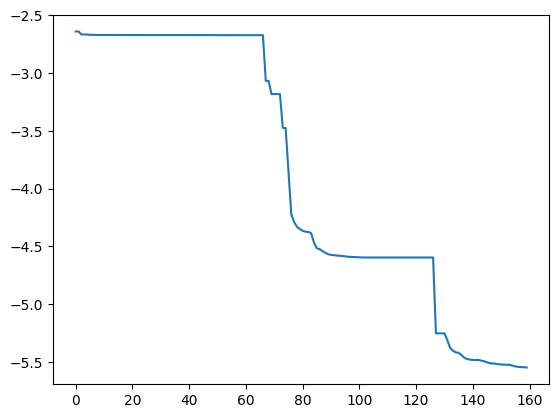

优化结果：
[124.64737424   3.13378975   0.           3.00971348   7.0859497
   0.           4.69280735   2.7491159 ]
最优参数:
 速度：124.6474,方向: 3.1338,
第一枚干扰弹释放时间: 0.0000,第一枚干扰弹弹击时间: 0.0000,
第二枚干扰弹释放时间: 3.0097,第二枚干扰弹弹击时间: 4.6928,
第三枚干扰弹释放时间: 7.0859,第三枚干扰弹弹击时间: 2.7491
最大覆盖值: 5.546011924743652


In [ ]:
from matplotlib import pyplot as plt
plt.plot(pso.gbest_y_hist)
plt.show()

# 输出结果
print("优化结果：")
best_params = pso.gbest_x  # 最优参数
best_value = -pso.gbest_y  # 还原为原函数的最大值（因目标函数取负）
print(best_params)
print(f"最优参数:\n 速度：{best_params[0]:.4f},方向: {best_params[1]:.4f},\n第一枚干扰弹释放时间: {best_params[2]:.4f},第一枚干扰弹弹击时间: {best_params[5]:.4f},\n第二枚干扰弹释放时间: {best_params[3]:.4f},第二枚干扰弹弹击时间: {best_params[6]:.4f},\n第三枚干扰弹释放时间: {best_params[4]:.4f},第三枚干扰弹弹击时间: {best_params[7]:.4f}")
print(f"最大覆盖值: {best_value}")

In [ ]:
print("计算各个干扰弹的遮蔽时长")
def calc_cover_intervals_single(f_speed, f_dir, t_release, t_burst,smoke_v0=-3, g=9.80665):
    """
    计算遮蔽时间区间（判定方式：直线与球心距离是否小于10）
    f_speed: 无人机速度(m/s)
    f_dir: 无人机运动方向(3维单位向量, 只能等高, z=0)
    t_release: 投放炸弹的时间(s)
    t_burst: 投放后多久炸弹起爆(s)
    smoke_v0: 烟幕弹竖直初速度(默认-3m/s)
    smoke_radius: 烟幕半径(默认7m)
    g: 重力加速度(默认9.80665)
    返回： 遮蔽区间列表，每个元素为(start, end)，以烟幕起爆时为0
    """
    # 固定参数
    m1 = np.array([20000, 0, 2000], dtype=np.float32)
    true_target = np.array([0, 200, 5], dtype=np.float32)
    v_m = 300  # m/s
    f1 = np.array([17800, 0, 1800], dtype=np.float32)  # 无人机1初始位置
    fake_target = np.array([0, 0, 0], dtype=np.float32)
    
    # 计算方向向量（向量化操作）
    dir_vec = (fake_target - m1) / np.linalg.norm(fake_target - m1)
    f_dir_vec = np.array([np.cos(f_dir), np.sin(f_dir), 0], dtype=np.float32)

    # 计算各关键时刻位置（向量化操作）
    missile_release = m1 + v_m * t_release * dir_vec
    f_release = f1 + f_speed * t_release * f_dir_vec
    
    # 烟幕弹起爆点（投放后t_burst秒，抛体运动）
    smoke_burst = np.array([
        f_release[0], 
        f_release[1], 
        f_release[2] + (-0.5) * g * t_burst**2
    ], dtype=np.float32)

    # 生成时间数组（向量化操作的基础）
    t_list = np.linspace(0, 20, 40001, dtype=np.float32)

    # 向量化计算导弹位置
    missile_positions = missile_release[:, np.newaxis] + v_m * (t_burst + t_list) * dir_vec[:, np.newaxis]

    # 向量化计算烟幕位置
    smoke_z = smoke_burst[2] + smoke_v0 * t_list
    smoke_positions = np.stack([
        np.full_like(t_list, smoke_burst[0]),
        np.full_like(t_list, smoke_burst[1]),
        smoke_z
    ], axis=0)

    # 计算导弹-真目标直线到烟幕球心的距离是否小于10
    missile_pos = missile_positions.T  # (N,3)
    smoke_pos = smoke_positions.T      # (N,3)
    target = true_target

    ab = target - missile_pos         # (N,3)
    ap = smoke_pos - missile_pos      # (N,3)
    ab_norm2 = np.sum(ab**2, axis=1)  # (N,)

    s = np.sum(ap * ab, axis=1) / ab_norm2
    closest = missile_pos + ab * s[:, None]  # (N,3)
    dist = np.linalg.norm(smoke_pos - closest, axis=1)  # (N,)

    in_smoke = dist <= 10

    # 检测区间（使用向量化操作替代循环）
    intervals = []
    if np.any(in_smoke):
        transitions = np.where(np.diff(in_smoke.astype(int)) != 0)[0]
        start = None
        if in_smoke[0]:
            start = t_list[0]
        for i in transitions:
            if start is None:
                start = t_list[i + 1]
            else:
                intervals.append((start, t_list[i + 1]))
                start = None
        if start is not None:
            intervals.append((start, t_list[-1]))
    print(f"本次参数{[f_speed, f_dir, t_release, t_burst]}")
    try:
        start = intervals[0][0]
        end = intervals[-1][1]
        total = sum(end - start for start, end in intervals)

        print(f"开始时间: {start:.4f}, 结束时间: {end:.4f}, 总时长: {total:.4f}s")
    except Exception:
        print(0)
for i in range(3):
    calc_cover_intervals_single(best_params[0], best_params[1],best_params[i + 2], best_params[i + 5])

计算各个干扰弹的遮蔽时长
本次参数[124.64737424097987, 3.133789747970531, 0.0, 0.0]
开始时间: 4.7640, 结束时间: 9.2580, 总时长: 4.4940s
本次参数[124.64737424097987, 3.133789747970531, 3.0097134837931816, 4.692807351400339]
0
本次参数[124.64737424097987, 3.133789747970531, 7.0859497003058225, 2.749115904370146]
0
